In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from tqdm import tqdm_notebook

from abc import abstractmethod, ABC


In [3]:
def rotate(y: np.array, a: float):
    x = np.diag(np.ones(len(y)))
    for i in range(5):
        j = 2 * i
        x[j][j] = np.sqrt(1 - a ** 2)
        x[j + 1][j] = a
        x[j][j + 1] = -a
        x[j + 1][j + 1] = np.sqrt(1 - a ** 2)
    z = x @ y
    return z
    

In [5]:
np.linalg.solve(
    [[2, 0], [0, 2]],
    [1, 1]
)

array([0.5, 0.5])

In [126]:
np.linalg.norm([2, 2, 2, 2])

4.0

In [178]:
def gen_enemy_estimation(g: np.ndarray, v: np.ndarray, cos_rot: float) -> np.array:
    if cos_rot > 0.999:
        return g
    gn = np.linalg.norm(g)
    vn = np.linalg.norm(v)
    sc = (g * v).sum()
    A = [[gn ** 2, sc], [sc, vn ** 2]]
    cos_phi_0 = sc / gn / vn
    sin_phi_0 = np.sqrt(1 - cos_phi_0 ** 2)
    cos_sum = cos_phi_0 * cos_rot - sin_phi_0 * np.sqrt(1 - cos_rot ** 2)
    b = [(gn ** 2) * (cos_rot ** 2), gn * vn * cos_sum * cos_rot]
    # print(A, b)
    cg, cv = np.linalg.solve(A, b)
    return cg * g + cv * v


In [179]:
g = np.array([3, 0])
v = np.array([0, 2])
a = 1 / np.sqrt(2)
est = gen_enemy_estimation(g, v, np.sqrt(1 - a ** 2))

print(np.linalg.norm(est - g), np.linalg.norm(g) * a, est)

2.121320343559642 2.1213203435596424 [ 1.5 -1.5]


In [180]:
class Relative(ABC):
    
    def __init__(self, alpha: float = 0.1, d: int = 11):
        self.alpha = alpha
        self.d = d

    def get_cos(self) -> float:
        return np.sqrt(1 - self.alpha ** 2)

    @abstractmethod
    def grad(self, x: np.ndarray) -> np.ndarray:
        pass

    def make_noise(self, x):
        noise = np.random.randn(self.d)
        g = self.grad(x)
        return np.linalg.norm(g) * self.alpha * noise / np.linalg.norm(noise)

    def estimation_grad(self, x):
        return self.grad(x) + self.make_noise(x)

    def estimation_grad(self, x):
        g = self.grad(x)
        estg = rotate(g, self.alpha)
        return (1 - self.alpha) * estg

    def estimation_grad(self, x):
        return self.grad(x) + self.make_noise(x)

    def estimation_grad(self, x, x_star = None):
        x_star = x_star if x_star is not None else np.zeros(self.d)
        g = self.grad(x)
        est = gen_enemy_estimation(g, x - x_star, self.get_cos())
        print(np.linalg.norm(est - g) / np.linalg.norm(g),
              ((g * (x - x_star)).sum() / np.linalg.norm(g) / np.linalg.norm(x - x_star)),
              (est * (x - x_star)).sum() / np.linalg.norm(est) / np.linalg.norm((x - x_star)))
        return est


class NesterovFunc(Relative):

    def __init__(self, alpha: float = 0.1, d: int = 11, L: float = 1, k: int = 11):
        super().__init__(alpha, d)
        self.L = L
        self.k = k

        self.x_star = 1 - np.array(list(np.arange(1, k + 1) / (d + 1)) + ([0] * (d - k)))
        self.A = np.diag(np.concatenate((-np.ones(k - 1), [0] * (d - k))), k=-1) \
                 + np.diag(np.concatenate((-np.ones(k - 1), [0] * (d - k))), k=1) \
                 + 2 * np.diag(np.concatenate((np.ones(k), [0] * (d - k))), k=0)
    
    def __call__(self, x: np.ndarray) -> float:
        return self.L / 8 * x.T @ self.A @ x - self.L / 4 * x[0]

    def grad(self, x: np.ndarray) -> np.ndarray:
        e0 = np.zeros(self.d)
        e0[0] = 1
        return self.L / 4 * (self.A @ x -  e0)


class SimpleFunc(Relative):

    def __init__(self, alpha: float = 0.1, L: float = 1):
        super().__init__(alpha, 2)
        self.L = L
        self.d = 2
        self.x_star = np.zeros(2)

    def __call__(self, x: np.ndarray) -> float:
        return self.L / 2 * x[0] ** 2

    def grad(self, x: np.ndarray) -> np.ndarray:
        return np.array([self.L * x[0], 0])



class NesterovMUFunc(Relative):

    def __init__(self, alpha: float = 0.1, d: int = 11, L: float = 10, mu: float = 1):
        super().__init__(alpha, d)
        self.L = L
        self.mu = mu
        self.A = np.diag(-np.ones(d - 1), k=-1) \
                 + np.diag(-np.ones(d - 1), k=1) \
                 + 2 * np.diag(np.ones(d), k=0)
        self.coef = self.L / self.mu

    def __call__(self, x: np.ndarray) -> float:
        return self.mu * (self.coef - 1) / 8 * (x.T @ self.A @ x  - 2 * x[0]) + self.mu / 2 * np.linalg.norm(x)

    def grad(self, x: np.ndarray) -> np.ndarray:
        e0 = np.zeros(self.d)
        e0[0] = 1
        return self.mu * (self.coef - 1) / 4 * (self.A @ x -  e0) + self.mu * x



class STM:

    def __init__(self, h, start, L, mu, func: Relative, disc = 1):
        self.h = h
        self.L = L
        self.mu = mu
        self.disc = disc
        # self.mu = mu
        self.a0 = 1 / L
        self.A0 = 1 / L
        self.cura = self.a0
        self.curA = self.A0
        self.y0 = start
        self.func = func
        self.z0 = start - h / L * func.estimation_grad(start, func.x_star)
        self.x0 = self.z0
        self.iter = 0
        self.y = [self.y0]
        self.z = [self.z0]
        self.x = [self.x0]

    def calc_psi(self):
        pass

    def step(self):
        self.iter += 1
        self.preva = self.cura
        self.prevA = self.curA
        t = (1 + self.mu * self.prevA)
        self.cura = t / 2 / self.L +\
                    + np.sqrt(t ** 2 / 4 / self.L / self.L
                              + self.prevA * t / self.L)
        self.curA = self.prevA + self.cura
        y = self.prevA / self.curA * self.x[-1] + self.cura / self.curA * self.z[-1]
        p = self.disc * self.z[-1] + (1 - self.disc) * self.y0
        p -= self.h * self.cura / (1 + self.mu * self.curA) * (
            self.func.estimation_grad(y, self.func.x_star) + self.mu * (self.z[-1] - y)
        )
        self.z.append(p)
        x = self.prevA / self.curA * self.x[-1] + self.cura / self.curA * self.z[-1]
        self.y.append(y)
        self.x.append(x)


def nesterov_plot(iters: int = 100):
    L = 1
    disc = 1
    dim = 1001
    k = 11
    start = np.ones(dim) * 1000
    # start = np.zeros(dim)
    # start[k - 1] = 100
    nesterov = NesterovFunc(L=L, d=dim, alpha=0.5, k=k)
    stm = STM(h=1, start=start, L=L, mu=0, func=nesterov, disc=disc)
    nesterov_true = NesterovFunc(L=L, d=dim, alpha=0, k=k)
    stm_true = STM(h=1, start=start, L=L, mu=0, func=nesterov_true)

    for _ in tqdm_notebook(range(iters)):
        stm.step()
        stm_true.step()
    with sns.plotting_context("notebook"), sns.axes_style("darkgrid"):
        plt.figure(figsize=(10, 6), dpi=120)
        xs = stm.x
        xst = stm_true.x
        values = [nesterov(x) for x in xs]
        plt.plot(np.arange(len(xs)), values, label="Noise")
        plt.plot(np.arange(len(xs)), [nesterov(x) for x in xst], label="Real")
        # plt.semilogy(np.arange(len(xs)), 100 / (1 + np.arange(len(xs))) ** 2)
        plt.legend()
        plt.show()
    return xs


def nesterov_mu_plot(iters: int = 100):
    L = 10000
    mu = 0.01
    disc = 1
    dim = 1000
    start = np.ones(dim) * 100
    nesterov = NesterovMUFunc(L=L, mu=mu, d=dim, alpha=0.5)
    stm = STM(h=0.1, start=start, L=L, mu=mu, func=nesterov, disc=disc)
    nesterov_true = NesterovMUFunc(L=L, mu=mu, d=dim, alpha=0)
    stm_true = STM(h=1, start=start, L=L, mu=mu, func=nesterov_true)
    
    for _ in tqdm_notebook(range(iters)):
        stm.step()
        stm_true.step()
    with sns.plotting_context("notebook"), sns.axes_style("darkgrid"):
        plt.figure(figsize=(10, 6), dpi=120)
        xs = stm.x
        xst = stm_true.x
        values = [nesterov(x) for x in xs]
        plt.plot(np.arange(len(xs)), values, label="Noise")
        plt.plot(np.arange(len(xs)), [nesterov(x) for x in xst], label="Real")
        # plt.semilogy(np.arange(len(xs)), 100 / (1 + np.arange(len(xs))) ** 2)
        plt.legend()
        plt.show()



In [185]:
def nesterov_plot(iters: int = 100):
    L = 1
    disc = 1
    dim = 1001
    k = 11
    start = np.ones(dim) * 1000
    # start = np.zeros(dim)
    # start[k - 1] = 100
    nesterov = NesterovFunc(L=L, d=dim, alpha=1.1, k=k)
    

    stm = STM(h=1, start=start, L=L, mu=0, func=nesterov, disc=disc)
    nesterov_true = NesterovFunc(L=L, d=dim, alpha=0, k=k)
    stm_true = STM(h=1, start=start, L=L, mu=0, func=nesterov_true)

    for _ in tqdm_notebook(range(iters)):
        stm.step()
        stm_true.step()
    with sns.plotting_context("notebook"), sns.axes_style("darkgrid"):
        plt.figure(figsize=(10, 6), dpi=120)
        xs = stm.x
        xst = stm_true.x
        values = [nesterov(x) for x in xs]
        plt.plot(np.arange(len(xs)), values, label="Noise")
        # plt.plot(np.arange(len(xs)), [nesterov(x) for x in xst], label="Real")
        # plt.semilogy(np.arange(len(xs)), 100 / (1 + np.arange(len(xs))) ** 2)
        plt.legend()
        plt.show()
    return xs

nan 0.044699275127883534 nan
0.0 0.044699275127883534 0.044699275127883534


/tmp/ipykernel_1514416/948498734.py:8: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(1 - self.alpha ** 2)
/tmp/ipykernel_1514416/494036485.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(iters)):


  0%|          | 0/100 [00:00<?, ?it/s]

nan nan nan
0.0 0.049992227834698096 0.049992227834698096
nan nan nan
0.0 0.05611351453285231 0.05611351453285231
nan nan nan
0.0 0.06190743891528507 0.06190743891528507
nan nan nan
0.0 0.06720233914102504 0.06720233914102504
nan nan nan
0.0 0.07201132480043912 0.07201132480043912
nan nan nan
0.0 0.07582909334372928 0.07582909334372928
nan nan nan
0.0 0.07696347141562203 0.07696347141562203
nan nan nan
0.0 0.07444605211668806 0.07444605211668806
nan nan nan
0.0 0.0696862157813265 0.0696862157813265
nan nan nan
0.0 0.06454469524461538 0.06454469524461538
nan nan nan
0.0 0.059827181414748395 0.059827181414748395
nan nan nan
0.0 0.055558668482369906 0.055558668482369906
nan nan nan
0.0 0.0515015793840053 0.0515015793840053
nan nan nan
0.0 0.047414572263016395 0.047414572263016395
nan nan nan
0.0 0.043155202841193875 0.043155202841193875
nan nan nan
0.0 0.03871285431201971 0.03871285431201971
nan nan nan
0.0 0.03418665932453108 0.03418665932453108
nan nan nan
0.0 0.029720921684556614 0.029

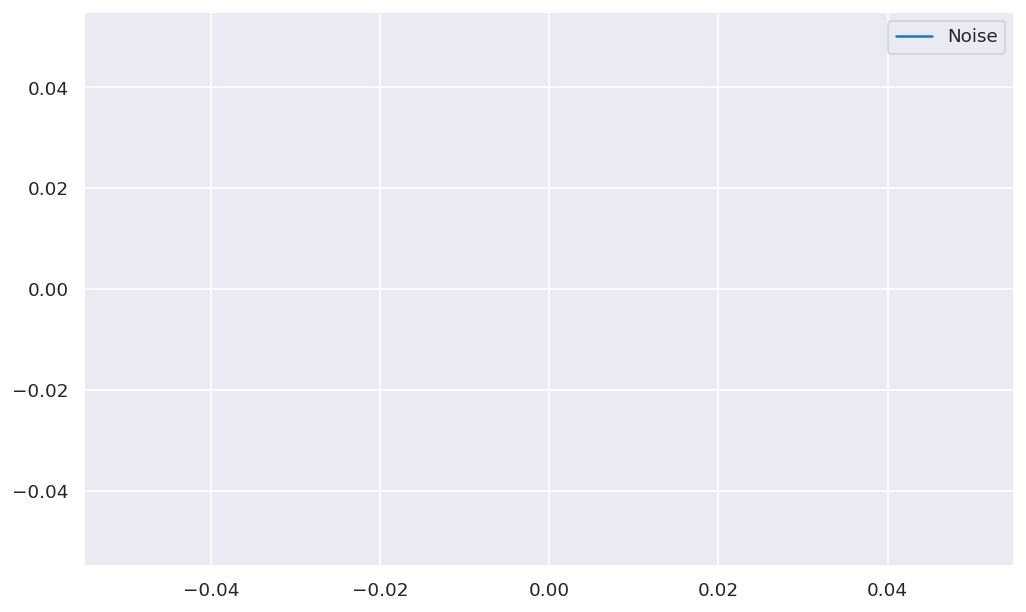

[array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([na

In [186]:
nesterov_plot(100)

In [181]:
def simple_plot(iters: int = 100):
    L = 1
    dim = 2
    # start = np.ones(dim) * 1
    start = np.zeros(dim)
    start[0] = 10
    start[1] = 10000
    simple = SimpleFunc(L=L, alpha=0.5)
    stm = STM(h=1, start=start, L=L, mu=0, func=simple, disc=1)
    simple_true = SimpleFunc(L=L, alpha=0)
    stm_true = STM(h=1, start=start, L=L, mu=0, func=simple_true)

    for _ in tqdm_notebook(range(iters)):
        stm.step()
        stm_true.step()
    with sns.plotting_context("notebook"), sns.axes_style("darkgrid"):
        plt.figure(figsize=(10, 6), dpi=120)
        xs = stm.x
        xst = stm_true.x
        values = [simple(x) for x in xs]
        plt.plot(np.arange(len(xs)), values, label="Noise")
        plt.plot(np.arange(len(xs)), [simple(x) for x in xst], label="Real")
        # plt.semilogy(np.arange(len(xs)), 100 / (1 + np.arange(len(xs))) ** 2)
        plt.legend()
        plt.show()
    return xs

0.5000000000000002 0.000999999500000375 -0.4991337250294157
0.0 0.000999999500000375 0.000999999500000375


/tmp/ipykernel_1514416/768791439.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(iters)):


  0%|          | 0/100 [00:00<?, ?it/s]

0.5 0.00024989178587687873 -0.4997835717537571
nan nan nan
0.5000000000000002 9.665687521345287e-06 -0.49999162924570534
nan nan nan
0.5000000000000001 2.3646464931661276e-05 -0.49997952142087076
nan nan nan
0.5000000000000001 1.0334066579225863e-05 -0.49999105040911973
nan nan nan
0.5 5.907966515893205e-07 -0.499999488355004
nan nan nan
0.5000000000000001 1.4329235730339547e-06 -0.49999875905127084
nan nan nan
0.5000000000000001 7.061266516426376e-07 -0.49999938847625675
nan nan nan
0.5000000000000002 4.5982122583640244e-08 -0.4999999601783133
nan nan nan
0.5000000000000001 1.1123945356109413e-07 -0.49999990366380437
nan nan nan
0.5000000000000001 5.7865145986624995e-08 -0.49999994988731283
nan nan nan
0.5000000000000001 4.0261931684702105e-09 -0.4999999965132146
nan nan nan
0.5 9.72923090120475e-09 -0.4999999915742389
nan nan nan
0.5000000000000001 5.220593378255374e-09 -0.4999999954788336
nan nan nan
0.5000000000000002 3.7820084480950484e-10 -0.49999999967246866
nan nan nan
0.500000

/tmp/ipykernel_1514416/948498734.py:34: RuntimeWarning: invalid value encountered in scalar divide
  print(np.linalg.norm(est - g) / np.linalg.norm(g),
/tmp/ipykernel_1514416/948498734.py:35: RuntimeWarning: invalid value encountered in scalar divide
  ((g * (x - x_star)).sum() / np.linalg.norm(g) / np.linalg.norm(x - x_star)),
/tmp/ipykernel_1514416/948498734.py:36: RuntimeWarning: invalid value encountered in scalar divide
  (est * (x - x_star)).sum() / np.linalg.norm(est) / np.linalg.norm((x - x_star)))


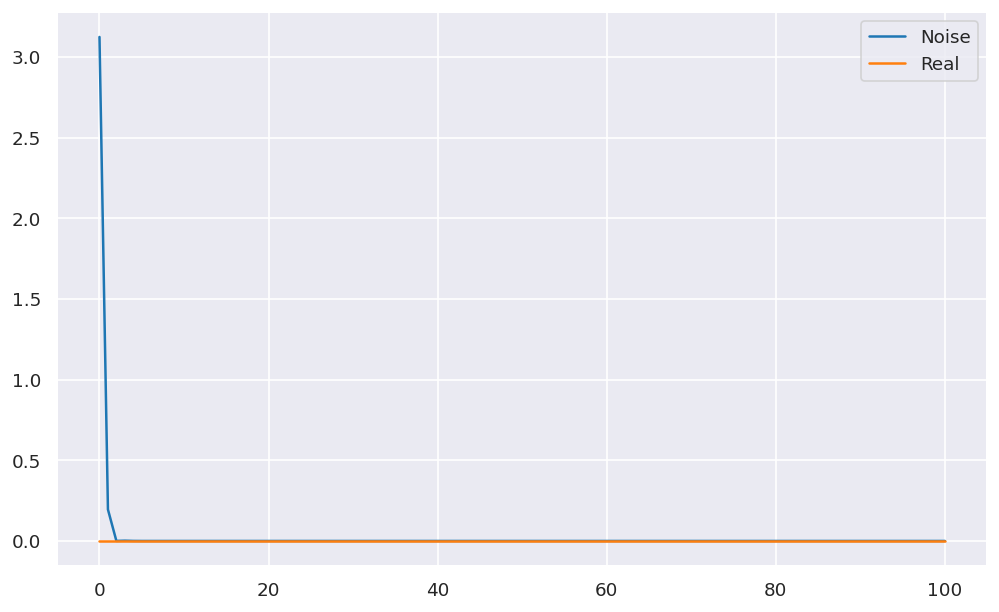

[array([2.50000000e+00, 1.00043301e+04]),
 array([6.25000000e-01, 1.00054127e+04]),
 array([2.41780351e-02, 1.00057595e+04]),
 array([-5.91511006e-02,  1.00060126e+04]),
 array([-2.58510471e-02,  1.00061917e+04]),
 array([-1.47792198e-03,  1.00063015e+04]),
 array([3.58459187e-03, 1.00063790e+04]),
 array([1.76645213e-03, 1.00064353e+04]),
 array([1.15029749e-04, 1.00064760e+04]),
 array([-2.78279572e-04,  1.00065068e+04]),
 array([-1.44757333e-04,  1.00065305e+04]),
 array([-1.00720749e-05,  1.00065491e+04]),
 array([2.43390428e-05, 1.00065640e+04]),
 array([1.30600662e-05, 1.00065761e+04]),
 array([9.46124821e-07, 1.00065860e+04]),
 array([-2.28493839e-06,  1.00065943e+04]),
 array([-1.25110541e-06,  1.00066013e+04]),
 array([-9.31371096e-08,  1.00066072e+04]),
 array([2.24850366e-07, 1.00066123e+04]),
 array([1.24880407e-07, 1.00066167e+04]),
 array([9.48098969e-09, 1.00066205e+04]),
 array([-2.28835400e-08,  1.00066238e+04]),
 array([-1.28445147e-08,  1.00066268e+04]),
 array([-9.8

In [182]:
simple_plot(100)

0.5099999999999985
2.2772628352479578e-16


/tmp/ipykernel_1514416/3071760584.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(iters)):


  0%|          | 0/100 [00:00<?, ?it/s]

0.5099999999999991
9.329839618943396e-18
0.5099999999999996
0.0
0.5100000000000007
1.5957920599280116e-16
0.5099999999999989
0.0
0.5100000000000003
2.1775353150011557e-16
0.5100000000000001
1.946693713815233e-16
0.5099999999999996
9.350372751200584e-18
0.5100000000000009
0.0
0.5099999999999999
0.0
0.5099999999999998
0.0
0.5099999999999997
2.1040348694107052e-16
0.5099999999999997
0.0
0.5100000000000007
0.0
0.5099999999999996
0.0
0.51
2.1089120388807819e-16
0.510000000000001
1.841528222327261e-16
0.5100000000000005
5.718802236649504e-18
0.5099999999999988
0.0
0.5100000000000001
0.0
0.5100000000000003
1.473922855368396e-16
0.5100000000000008
2.6296983857207813e-18
0.5100000000000001
1.7670259160240682e-16
0.5099999999999991
2.1426121027792394e-16
0.5100000000000007
2.303853993260779e-16
0.5099999999999999
2.0116700304973345e-16
0.5099999999999978
4.621228472607787e-19
0.5100000000000025
0.0
0.5099999999999986
0.0
0.5099999999999979
0.0
0.5099999999999859
0.0
0.5099999999999733
0.0
0.5099

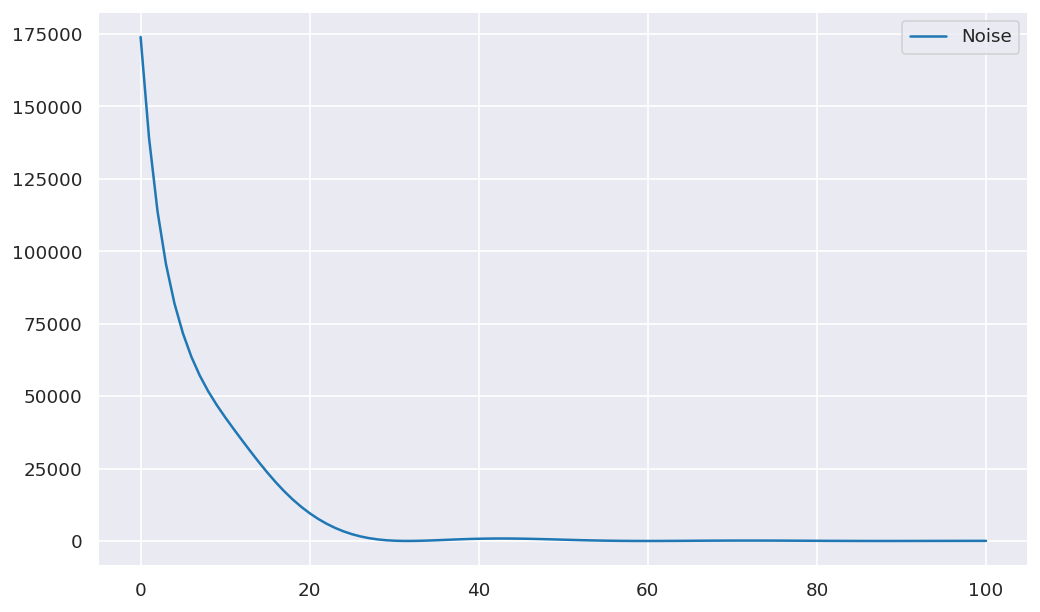

[array([815.2075447 , 995.09529773, 995.09529284, ..., 995.09530753,
        995.09530753, 995.09530753]),
 array([698.52493513, 959.51876455, 991.85673102, ..., 991.85675543,
        991.85675543, 991.85675543]),
 array([595.89846691, 903.9134397 , 981.28711483, ..., 988.71650017,
        988.71650017, 988.71650017]),
 array([510.78951933, 836.95920307, 959.6695716 , ..., 985.71962067,
        985.71962067, 985.71962067]),
 array([442.05148423, 766.69800558, 926.70353403, ..., 982.86244534,
        982.86244534, 982.86244534]),
 array([386.94601011, 698.75301589, 884.65929941, ..., 980.13145518,
        980.13145518, 980.13145518]),
 array([342.60512337, 636.23866665, 836.93259382, ..., 977.51220816,
        977.51220816, 977.51220816]),
 array([306.58292432, 580.38566868, 786.86405865, ..., 974.98963168,
        974.98963168, 974.98963168]),
 array([276.96140568, 531.2659561 , 737.09223005, ..., 972.54463092,
        972.54463092, 972.54463092]),
 array([252.28687848, 488.35803642, 6

In [149]:
nesterov_plot(100)

/tmp/ipykernel_1309073/2715278813.py:148: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(iters)):


  0%|          | 0/1000 [00:00<?, ?it/s]

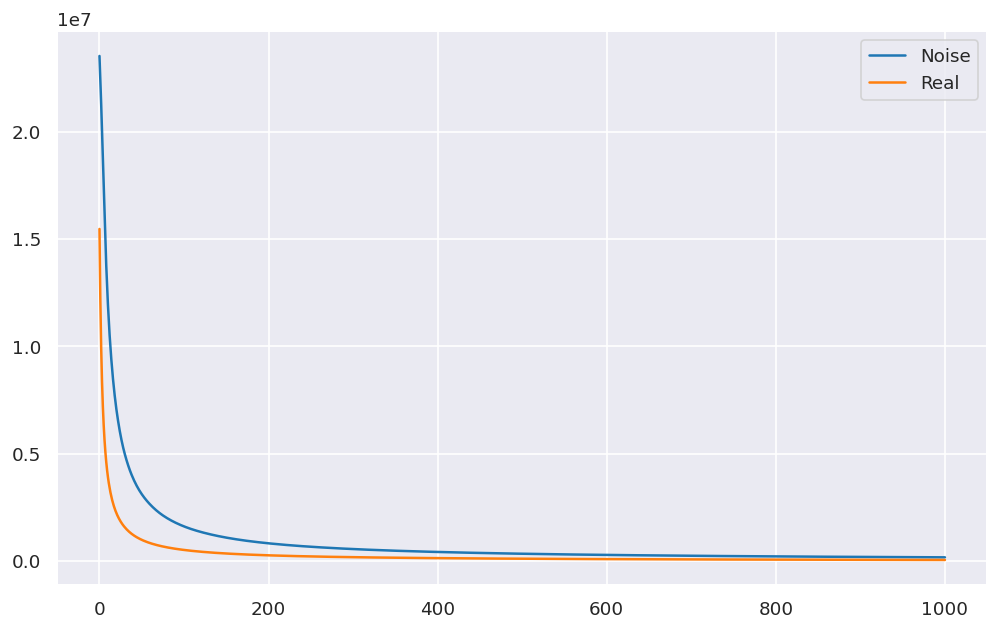

In [268]:
nesterov_mu_plot(iters=1000)

In [133]:
nesterov = NesterovFunc(L=10, d=100, alpha=0)
start = np.ones(100) * 100
stm = STM(h=1, start=start, L=10, func=nesterov)

for _ in tqdm_notebook(range(100)):
    stm.step()


/tmp/ipykernel_1309073/4116619246.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(100)):


  0%|          | 0/100 [00:00<?, ?it/s]

In [138]:
stm.curA * 40, 100 ** 2

(10809.452507864007, 10000)

In [37]:
f = NesterovFunc(d=3)

In [39]:
f(np.ones(3))

0.0

In [23]:
np.ones(11).T @ np.diag(11) @ np.ones(11)

ValueError: Input must be 1- or 2-d.